In [0]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm, trange
import os
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# CHANGE THIS IF WORKING LOCALLY
# DATA_PATH = './data/'
DATA_PATH = './drive/My Drive/Thesis/'

In [0]:
df = pd.read_csv(DATA_PATH + 'links.tsv', sep='\t', skiprows=11, header=None)
df.columns = ['source', 'target']
df.head()

,source,target
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


In [0]:
wiki_graph = nx.from_pandas_edgelist(df, create_using=nx.DiGraph())
gcc = max(nx.strongly_connected_components(wiki_graph), key=len)
gcc = wiki_graph.subgraph(gcc)

In [0]:
len(wiki_graph.nodes())

4592

In [0]:
articles = pd.read_csv(DATA_PATH + 'articles.tsv', sep='\t', skiprows=11, header=None).reset_index()
articles.columns = ['index', 'article']
art_to_id = articles.set_index('article')['index'].to_dict()
id_to_art = articles.set_index('index')['article'].to_dict()
articles.head()

,index,article
0,0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in
1,1,%C3%85land
2,2,%C3%89douard_Manet
3,3,%C3%89ire
4,4,%C3%93engus_I_of_the_Picts


In [0]:
id_to_art[4]

'%C3%93engus_I_of_the_Picts'

In [0]:
isolated_nodes = set.difference(set(articles['article']), set(wiki_graph.nodes()))
wiki_graph.add_nodes_from(isolated_nodes)
len(wiki_graph.nodes())

4604

In [0]:
'Wowpurchase' in wiki_graph.nodes()

True

In [0]:
len(gcc.nodes())

4051

In [0]:
gcc_strong_nodes = max(nx.strongly_connected_components(wiki_graph), key=len)
diff_nodes = set.difference(set(wiki_graph.nodes), gcc_strong_nodes)  
len(diff_nodes)

553

In [0]:
def get_edge_seq(path):
  parts = path.split(";")
  
  edges = np.zeros(len(parts)-1, dtype=object)
  last = []
  last_val = str()
  cpy = np.zeros(len(parts), dtype=object)
  cpy[0] = parts[0]
  for i in range(1, len(parts)):
    if parts[i] != "<":
      cpy[i] = parts[i]
      
      if parts[i-1] == "<":
        last.append(last_val)
      else:
        last.append(parts[i - 1])
    else:
      cpy[i] = last.pop()
      last_val = cpy[i]
  
  for i in range(len(parts)-1):
    edges[i] = (cpy[i], cpy[i+1])
      
  return edges.tolist()

In [0]:
paths_df = pd.read_csv(DATA_PATH + 'paths_finished.tsv', sep='\t', skiprows=16, header=None).reset_index()
paths_df.columns = ['index', 'hashedIP', 'tstamp', 'durationSec', 'path', 'rating']
paths_df.head()

,index,hashedIP,tstamp,durationSec,path,rating
0,0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [0]:
tuples = [get_edge_seq(val) for val in paths_df['path'].values]

In [0]:
edgelist = []
for i in range(len(tuples)):
  edgelist += tuples[i]

In [0]:
paths = nx.MultiDiGraph()
paths.add_edges_from(edgelist)
len(paths.edges())

295460

In [0]:
def simplify_with_weights(G):
  Gs = nx.DiGraph()

  for u,v in G.edges():
    if (u, v) in Gs.edges():
      Gs[u][v]['weight'] += 1
    else:
      Gs.add_edge(u, v, weight=1)
      
  return Gs

In [0]:
paths_weighted = simplify_with_weights(paths)

In [0]:
# avoid only source - no
def uniform_prob(graph, u, id_to_art):
  neighbors = list(graph.neighbors(u))
  idx = -1
  if len(neighbors) == 0:
    idx = np.random.randint(0, len(graph))
    return id_to_art[idx]
  else:
    idx = np.random.randint(0, len(neighbors))
    return neighbors[idx]


def get_path_weights(graph, u, Gw, id_to_art):
  candidates = list(graph.neighbors(u))
  weights = []
  for n in candidates:
    if (u, n) in Gw.edges():
      weights.append(Gw[u][n]['weight'] + 1)
    else:
      weights.append(1)
  
  weights = np.array(weights) / sum(weights)

  if len(weights) == 0:
    candidates = id_to_art
    weights = np.ones(len(graph)) * (1 / len(graph))
  
  return weights, candidates

# when there is no transition in weighted graph we treat weight as 1, since it is present in wiki graph and there
# should be small probability to transit to this node even in case noone made such a move in games.
def path_prob(graph, u, Gw, id_to_art, visited):
  if u in visited:
    weights, candidates = visited[u]
  else:
    weights, candidates = get_path_weights(graph, u, Gw, id_to_art)
    visited[u] = (weights, candidates)
  idx = np.random.choice(len(weights), p = weights)
  return candidates[idx]

# This is version when rows of similarity matrix are rearranged
# def tf_idf_prob(graph, u, sim_mat, dist_mat, name_to_idx, idx_to_name, dist_name_to_idx, diff_idx, alpha):
#     idx = name_to_idx[u]
#     u_similarities = sim_mat[idx].T
    
#     # set probability to zero for nodes that are not in GCC
#     # UPDATE: probably redundant now, since denominator will be np.inf
#     u_similarities[diff_idx] = 0
#     denom = np.zeros_like(u_similarities)
    
#     for v in graph.nodes():
#         i = name_to_idx[v]
        
#         if u == v:
#             denom[i] = np.inf
#             continue
        
#         dist = dist_mat[dist_name_to_idx[u]][dist_name_to_idx[v]]
#         denom[i] = dist ** alpha
        
#     weights = u_similarities / denom
#     weights = weights / sum(weights)
    
#     #zero prob to jump to current node
#     weights[idx] = 0
    
#     idx = np.random.choice(len(u_similarities), p = weights)
#     res = idx_to_name[idx]
            
#     return res


def get_tf_idf_weights(graph, u, sim_mat, dist_mat, name_to_idx, idx_to_name, alpha, frac, debug=False):
    idx = name_to_idx[u]
    u_similarities = sim_mat[idx]

    # print(u_similarities.shape)
    
    # set probability to zero for nodes that are not in GCC
    # UPDATE: probably redundant now, since denominator will be np.inf
    # u_similarities[diff_idx] = 0

    denom = dist_mat[idx] ** alpha
    
    #set distance to itself to infinity in order not to jump to it
    denom[denom == 0] = np.inf
    # print("DENOM: ", denom.shape)
    if len(denom[denom == 0]) != 0:
      print(len(denom[denom == 0]))
        
    weights = u_similarities / denom

    #zero prob to jump to current node
    weights[idx] = 0

    s = sum(weights)
    weights = weights / s
    
    #dead end
    if(s == 0):
      weights = np.ones(len(weights)) / (len(weights))

    return weights

# This is simple version
def tf_idf_prob(graph, u, sim_mat, dist_mat, name_to_idx, idx_to_name, alpha, visited, frac, debug=False):
    if u in visited:
      weights = visited[u]
    else:
      weights = get_tf_idf_weights(graph, u, sim_mat, dist_mat, name_to_idx, idx_to_name, alpha, frac, debug)
      visited[u] = weights

    idx = np.random.choice(len(weights), p = weights)
    res = idx_to_name[idx]

    if debug:
      n = 10
      is_in_top_n = idx in ((np.argsort(weights)[::-1])[:n])
      # print("IN TOP {}: ".format(n), is_in_top_n)

      if is_in_top_n == True:
        frac.append(1)
      else:
        frac.append(0)

      print('TOP {} results: '.format(n))
      for i in np.argsort(weights)[::-1][:n]:
        print(weights[i], idx_to_name[i])

      print('Choice: ', weights[idx], res)
            
    return res

def corr_for_node(u_idx, adj_mat, neighbor_idx, indices=None, normalize=True):
  """
  Computes Pearson correlation of node u (represented by u_idx) and nodes in indices.
  If indices is None, then correlations will be computed for every other possible
  node, i. e. with nodes at distance at most 2.
  """

  if indices is None:
    #at most 2 nearest neighbors
    neighbors = adj_mat[neighbor_idx]
  else:
    neighbors = adj_mat[indices]


  # print("neighbors:", np.alltrue(~np.isnan(neighbors)))
  u_adj = adj_mat[u_idx]

  u_cent = u_adj - (np.sum(u_adj) / len(adj_mat))
  u_std = np.sqrt(np.sum(u_cent ** 2))
  if u_std == 0:
    u_std = 1

  #VECTORIZED IMPLEMENTATION:
  n_cent = neighbors - np.mean(neighbors, axis=1).reshape(-1,1)
  covs = np.dot(n_cent, u_cent)
  n_std = np.sqrt(np.sum(n_cent ** 2, axis=1))
  n_std[n_std == 0.0] = 1

  # print("nstd: ", n_std)
  # print('ustd: ', u_std)

  corrs = covs / (n_std * u_std)

  # set correlation with itself to zero
  corrs[corrs >= 0.999] = 0

  # normalize
  if normalize:
    corrs = (corrs + 1) / 2
  
  if indices is None:
    #this is valid only when there is no restriction on next target (d <= 2)
    corrs[u_idx] = 0
  else:
    if u_idx==indices[0]:
      print("!")
      corrs = [0]

  # Scalar implementation
  # correlations = []
  # for n in neighbors:

  #   if np.alltrue(u_adj == n):
  #     # zero probability to jump to itself
  #     correlations.append(0)
  #     continue

  #   n_exp = n - (np.sum(n) / len(n))
  #   n_std = np.sqrt(np.sum(n_exp ** 2))
  #   n_std = n_std if n_std != 0 else 1
    
  #   corr = np.sum(u_cent * n_exp) / (u_std * n_std)

  #   if np.isnan(corr):
  #     print("!!!")
  #     print(n_exp)
  #     print('all zero: ', np.alltrue(n_exp == 0))
  #     print(n_std)

  #   correlations.append(corr)

  # # print(correlations)
  # correlations = np.array(correlations)
  # #normalize
  # correlations = (correlations + 1) / 2

  # print('correlations shape: ', correlations.shape)
  # print("CORRS EQUAL: ", np.allclose(correlations, corrs))
  # if not np.allclose(correlations, corrs):
  #   print('corrs:', corrs)
  #   print('correlations: ', correlations)

  # weights = np.array(correlations) / sum(correlations)


  return corrs

def get_pearson_weights(graph, u, adj_mat, dist_mat, name_to_idx, idx_to_name):
  idx = name_to_idx[u]

  row = dist_mat[idx]
  # if np.alltrue(row == 0):
  #   print("Isolated node!!")
    
  # neighbor_idx = np.flatnonzero(row <= 2)
  neighbor_idx = np.arange(len(row))
  corrs = corr_for_node(idx, adj_mat, neighbor_idx)

  weights = corrs / sum(corrs)

  return weights, neighbor_idx

def pearson_prob(graph, u, adj_mat, dist_mat, name_to_idx, idx_to_name, visited):
  if u in visited:
    weights, neighbor_idx = visited[u]

  else:
    weights,neighbor_idx = get_pearson_weights(graph, u, adj_mat, dist_mat, name_to_idx, idx_to_name)
    visited[u] = (weights, neighbor_idx)

  idx = np.random.choice(neighbor_idx, p = weights)

  return idx_to_name[idx]


def combined_prob(importances, graph, u, sim_mat, dist_mat, adj_mat, 
                  name_to_idx, idx_to_name, alpha, frac, debug=False):
  uniform_weights = 1 / len(list(graph.neighbors(u)))
  path_weights = get_path_weights(graph, u, Gw)
  tf_idf_weights = get_tf_idf_weights(graph, u, sim_mat, dist_mat, name_to_idx, idx_to_name, alpha, frac, debug)
  pearson_weights = get_pearson_weights(graph, u, adj_mat, dist_mat, name_to_idx, idx_to_name)

  weights = np.array([uniform_weights, path_weights, tf_idf_weights, pearson_weights])

  lin_comb = weights.dot(importances.reshape(-1, 1)).sum(axis=0)
  lin_comb = lin_comb / sum(lin_comb)

  idx = np.random.choice(neighbor_idx, p = lin_comb)

  return idx_to_name[idx]



def random_walk(graph, source, num_iter, show_rw_progress, trans_func, *args):
  path = [source]
  curr = source
  
  iterable = tqdm(range(num_iter)) if show_rw_progress else range(num_iter)

  for i in iterable:
    next_el = trans_func(graph, curr, *args)
    path.append(next_el)
    curr = next_el
    
  return path

In [0]:
dist_path = DATA_PATH + 'shortest-path-distance-matrix.txt'

dists =[]
with open(dist_path, encoding='utf8') as f:
    data = f.readlines()[17:]
    for line in tqdm(data):
        line = line.strip('\n').strip()
        n_list = list(map(lambda x: int(x) if x != '_' else np.inf, line))
        dists.append(n_list)
        
dists = np.array(dists)
dists.shape

(4604, 4604)

In [0]:
adj_mat = nx.adjacency_matrix(wiki_graph, weight=None).toarray()
# adj_mat = nx.adjacency_matrix(gcc, weight=None).toarray()

In [0]:
# My similarity matrix with cosine similarity:
# similarities = np.load(DATA_PATH + 'similarities(1).npy')

# Dot product instead of cosine similarity:
!7z x './drive/My Drive/Thesis/sim (1).zip'
similarities = []
with open('sim.txt') as f:
  for line in tqdm(f):
    line = line.split(',')
    line = list(map(lambda x: float(x), line))
    similarities.append(line)

similarities = np.array(similarities)
similarities.shape


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan ./drive/My Drive/Thesis/                                  1 file, 175546031 bytes (168 MiB)

Extracting archive: ./drive/My Drive/Thesis/sim (1).zip
--
Path = ./drive/My Drive/Thesis/sim (1).zip
Type = zip
Physical Size = 175546031

  0%      3% - sim.txt                6% - sim.txt                9% - sim.txt               11% - sim.txt               14% - sim.txt               16% - sim.txt               18% - sim.txt               22% - sim.txt              

(4604, 4604)

### GCC Distances (redundant)

In [0]:
# get distance matrix only for strongly connected component
gcc_dists = []
print(dists.shape)
for i in trange(len(dists)):
  r = []
  if id_to_art[i] in gcc_strong_nodes:
    for j in range(len(dists)):
      if id_to_art[j] in gcc_strong_nodes:
        r.append(dists[i][j])
    gcc_dists.append(r)

gcc_dists = np.array(gcc_dists)
gcc_dists.shape

  1%|          | 43/4604 [00:00<00:10, 428.87it/s]

(4604, 4604)


100%|██████████| 4604/4604 [00:11<00:00, 402.20it/s]


(4051, 4051)

## Experiments

In [0]:
def run_experiments(n, graph, source, dist_mat, name_to_idx, num_iter, show_rw_progress, trans_func, *args):
  paths = []
  spls = []
  for i in tqdm(range(n)):
    path = random_walk(graph, source, num_iter, show_rw_progress, trans_func, *args)
    lengths = []
    
    s_i = name_to_idx[source]
    for node in path:
      s_j = name_to_idx[node]
      if not np.isinf(dist_mat[s_i][s_j]):
        lengths.append(dist_mat[s_i][s_j])
      else:
        lengths.append(np.nan)
      
    # for node in path:
    #   try:
    #     lengths.append(nx.shortest_path_length(graph, source=source, target=node))
    #   except nx.NetworkXNoPath:
    #     lengths.append(np.nan)
    #     # do not count non-existent paths
    #     # continue

    spls.append(lengths)
    paths.append(path)
  
  spls = np.array(spls)
  mean_dists = np.nanmean(spls, axis=0)

  return paths, mean_dists


def deg_vs_visitance(n, graph, source, name_to_idx, num_iter, show_rw_progress, trans_func, *args):
  node_to_visits = {}
  for i in tqdm(range(n)):
    path = random_walk(graph, source, num_iter, show_rw_progress, trans_func, *args)
    rw = pd.Series(path)
    rd = rw.value_counts().to_dict()
    
    for k in rd:
      if k in node_to_visits:
        node_to_visits[k] += rd[k]
      else:
        node_to_visits[k] = rd[k]

  node_to_degree = dict(graph.degree)

  nodes_info = {node:(node_to_degree[node], nvisits) for node,nvisits in node_to_visits.items()}

  return nodes_info

# THINK ABOUT UNIQUE ITEMS
def sim_with_time(sim_func, n, graph, source, name_to_idx, num_iter, show_rw_progress, trans_func, *args):
  sims = []
  for i in tqdm(range(n)):
    path = random_walk(graph, source, num_iter, show_rw_progress, trans_func, *args)
    sim = []
    if i <= 2:
      print(path)
    for p in path:
      sim.append(sim_func(source, p))
      # if source == p:
      #   print("!!")
    
    sims.append(sim)

  sims = np.array(sims)
  mean_sims = np.nanmean(sims, axis=0)

  return mean_sims

def display_results(values, source, prob, ylabel, save=True): 
  plt.grid(linestyle='dotted')
  plt.title('Source node: {}, transition probability: {}'.format(source, prob))
  plt.ylabel(ylabel)
  plt.xlabel('Timesteps')
  # plt.xlim(left=1,right=105)
  plt.plot(np.arange(1,101,1), values[1:])
  
  if save:
    if prob.startswith('tf-idf'):
      plt.savefig(prob[:-12]+ ' alpha = {}'.format(prob[-2:-1])+ '_dists.eps', format='eps', bbox_inches='tight', dpi=96)
    else:
      plt.savefig(prob + '_dists.eps', format='eps', bbox_inches='tight', dpi=96)
  

def plot_deg_vs_visitance(nodes_info, name, save=True):
  degrees = []
  visits = []
  for x,y in nodes_info.values():
    degrees.append(x)
    visits.append(y)

  corr = np.corrcoef(degrees,visits)[0][1]
  title = r'{}, $\rho$ = {}'.format(name, np.round(corr, 3))
  plt.grid(linestyle='dotted')
  plt.title(title)
  plt.xlabel('Degree')
  plt.ylabel('Number of visits')
  plt.scatter(degrees,visits,marker='.')

  if save:
    if name.startswith('tf-idf'):
      plt.savefig(name[:-12]+ ' alpha = {}'.format(name[-2:-1])+ '_deg_vis.eps', format='eps', bbox_inches='tight', dpi=96)
    else:
      plt.savefig(name + '_deg_vis.eps', format='eps', bbox_inches='tight', dpi=96)

In [0]:
nodes_info = deg_vs_visitance(1000, wiki_graph, 'Monarchy', art_to_id, 1000, False, path_prob, paths_weighted, id_to_art)

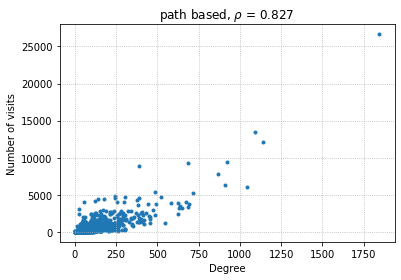

In [0]:
plot_deg_vs_visitance(nodes_info, 'path based')

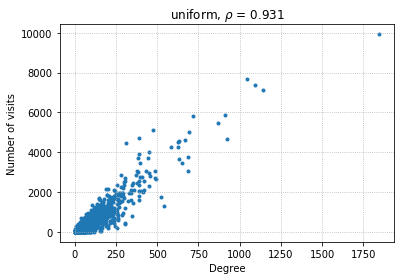

In [0]:
nodes_info = deg_vs_visitance(1000, wiki_graph, 'Monarchy', art_to_id, 1000, False, uniform_prob, id_to_art)
plot_deg_vs_visitance(nodes_info, 'uniform')

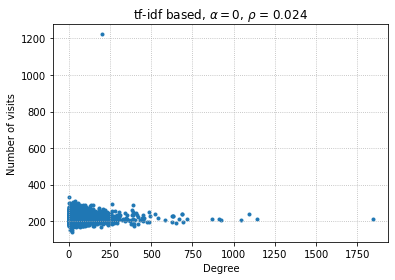

In [0]:
alpha = 0
nodes_info = deg_vs_visitance(1000, wiki_graph, 'Monarchy', art_to_id, 1000, False, tf_idf_prob, similarities, dists,
                                    art_to_id, id_to_art, alpha, [])
plot_deg_vs_visitance(nodes_info, 'tf-idf based, $\\alpha = 0$')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


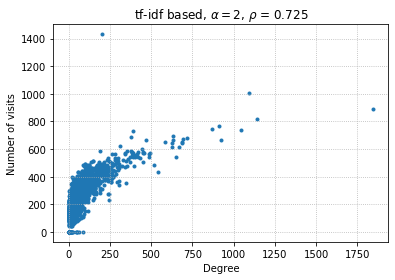

In [0]:
alpha = 2
nodes_info = deg_vs_visitance(1000, wiki_graph, 'Monarchy', art_to_id, 1000, False, tf_idf_prob, similarities, dists,
                                    art_to_id, id_to_art, alpha, [])
plot_deg_vs_visitance(nodes_info, 'tf-idf based, $\\alpha = 2$')

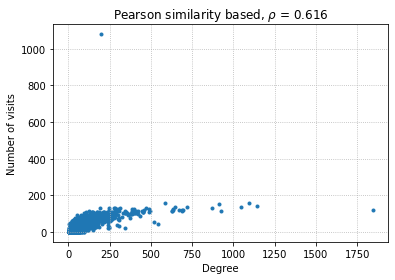

In [0]:
nodes_info = deg_vs_visitance(1000, wiki_graph, 'Monarchy', art_to_id,
                                    100, False, pearson_prob, adj_mat, dists,
                                    art_to_id, id_to_art, {})
plot_deg_vs_visitance(nodes_info, 'Pearson similarity based')

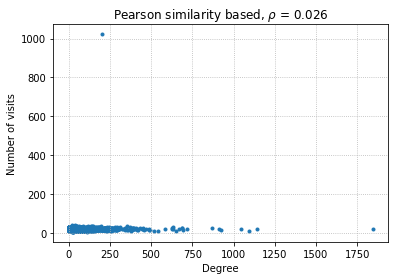

In [0]:
#PEARSON WITH NO DISTANCE RESTRICTION (DIST<=2)
nodes_info = deg_vs_visitance(1000, wiki_graph, 'Monarchy', art_to_id,
                                    100, False, pearson_prob, adj_mat, dists,
                                    art_to_id, id_to_art, {})
plot_deg_vs_visitance(nodes_info, 'Pearson similarity based')

In [0]:
m = 0
node = None
deg = None
for k,v in nodes_info.items():
  if v[1] > m:
    m = v[1]
    node = k
    deg = v[0]

print(node, deg, m)

Monarchy 200 1079


In [0]:
for d in wiki_graph.degree:
  if d[1] == 200:
    print(d)

('Monarchy', 200)
('Vietnam', 200)


In [0]:
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id, 100, False, path_prob, paths_weighted, id_to_art)

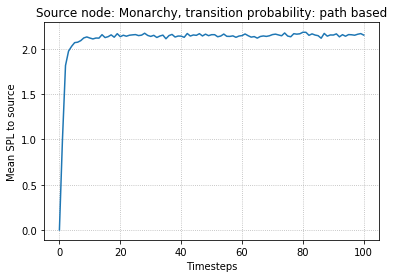

In [0]:
display_results(mean_dists, 'Monarchy', 'path based', 'Mean SPL to source')

In [0]:
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id, 100, False, uniform_prob, id_to_art)

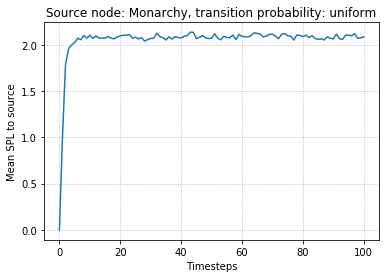

In [0]:
display_results(mean_dists, 'Monarchy', 'uniform', 'Mean SPL to source')

In [0]:
# fnames = os.listdir('C:\\Users\\Max\\Documents\\UCU MSc Data Science\\Thesis\\data\\plaintext_articles')
# fnames = [f[:-4] for f in fnames]
# fnames = pd.Series(fnames)
# np.alltrue(articles[0] == sorted(fnames))

True

In [0]:
# fnames = os.listdir('C:\\Users\\Max\\Documents\\UCU MSc Data Science\\Thesis\\data\\plaintext_articles')
# fnames = [f[:-4] for f in fnames]
# name_to_idx = {name:i for i,name in enumerate(fnames)}
# idx_to_name = {i:name for i,name in enumerate(fnames)}

(4604, 4604)

In [0]:
alpha = 2
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id,
                                    100, False, tf_idf_prob, similarities, dists,
                                    art_to_id, id_to_art, alpha, [])
# run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id, 100, False, uniform_prob, id_to_art)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in true_divide


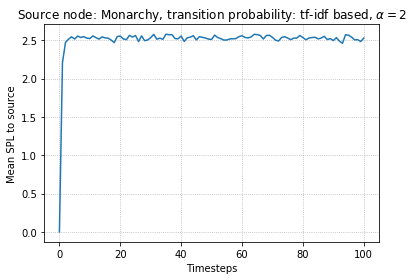

In [0]:
display_results(mean_dists, 'Monarchy', 'tf-idf based, $\\alpha=2$', 'Mean SPL to source')

In [0]:
alpha = 0
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id,
                                    100, False, tf_idf_prob, similarities, dists,
                                    art_to_id, id_to_art, alpha, [])

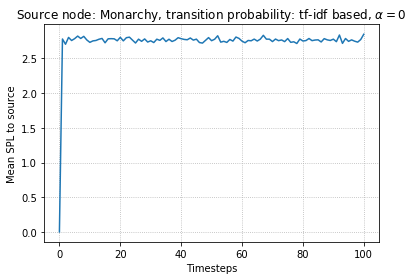

In [0]:
display_results(mean_dists, 'Monarchy', 'tf-idf based, $\\alpha=0$', 'Mean SPL to source')

In [0]:
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id,
                                    100, False, pearson_prob, adj_mat, dists,
                                    art_to_id, id_to_art, {})

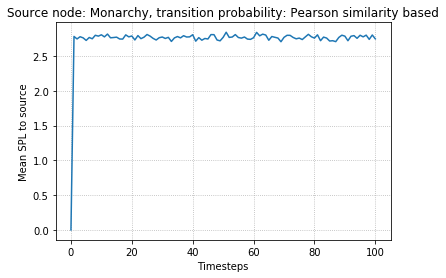

In [0]:
display_results(mean_dists, 'Monarchy', 'Pearson similarity based', 'Mean SPL to source')

In [0]:
mean_sims_path = sim_with_time(lambda s,x: paths_weighted[s][x]['weight'] 
                               if (s,x) in paths_weighted.edges() else 1,
1000, wiki_graph, 'Monarchy', art_to_id, 100, False, path_prob, paths_weighted, id_to_art, {})

['Monarchy', 'Sweden', 'Middle_Ages', 'English_language', 'South_Africa', 'Johannesburg', 'Time_zone', 'Earth', 'Sun', 'Mexico', 'Latin_America', 'Brazil', 'Rainforest', 'Insect', 'Animal', 'Plant', 'Gardening', 'Park', 'Royal_Parks_of_London', 'England', 'Portuguese_language', 'Vulgar_Latin', 'Roman_Empire', 'Roman_Britain', 'Franks', 'Attila_the_Hun', 'Europe', 'Iceland', 'Temperate', 'Weather', 'Earth%27s_atmosphere', 'Planet', 'Earth', 'Asia', 'Uzbekistan', 'Aral_Sea', 'Soviet_Union', 'Moscow', 'Russia', 'Natural_gas', 'Ocean', 'Krill', 'Soviet_Union', 'Afghanistan', 'World_Heritage_Site', 'North_America', 'California', 'United_States', 'Baseball', 'Babe_Ruth', 'Baseball', 'Sport', 'Football', 'Football_%28soccer%29', 'England', 'Anno_Domini', 'Hebrew_calendar', 'New_moon', 'Moon', 'Solar_System', 'Earth', 'Water', 'Ice', 'Energy', 'Electron', 'Niels_Bohr', 'Ernest_Rutherford', 'Rutherfordium', 'Carbon', 'Periodic_table', 'Hydrogen', 'Schr%C3%B6dinger_equation', 'Time', 'Art', 'Pai

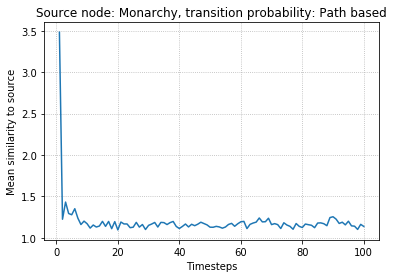

In [0]:
display_results(mean_sims_path, 'Monarchy', 'Path based', 'Mean similarity to source')

['Monarchy', 'Short-beaked_Echidna', 'Deity', 'Sumo', 'African_Buffalo', 'Double-decker_bus', 'The_Count_of_Monte_Cristo', 'Francis_Drake', 'Republic_of_the_Congo', 'One_Flew_Over_the_Cuckoo%27s_Nest_%28novel%29', 'Set', 'Eocene', 'Emma_Roberts', 'Victoria_of_the_United_Kingdom', 'Peace', '16th_century', 'Sydney', 'Arsenic', 'Irish_theatre', 'Henry_Purcell', 'Upsilon_Andromedae_d', 'Marie_Curie', 'Bluetooth', 'Agnosticism', 'Gustav_Holst', 'War_and_Peace', 'Herbert_Hoover', 'Arnold_Schwarzenegger', 'The_West_Wing_%28TV_series%29', 'Saudi_Arabia', 'Harold_Wilson', 'Euphrates', 'Angel_shark', 'List_of_Canadian_provinces_and_territories_by_area', 'Alliterative_verse', 'Chicago', 'Hippopotamus', 'Indian_Ocean', 'Newmarket', 'Angel_shark', 'William_N._Page', 'Bogot%C3%A1', 'Lake_Albert', 'Theta', 'Franklin_B._Gowen', 'Reza_Shah', '2005_Hertfordshire_Oil_Storage_Terminal_fire', 'Royal_National_Theatre', 'Cyclone_Percy', 'Sesame', 'Trichinosis', 'James_Joyce', 'Temperate', 'Canadian_Pacific_R

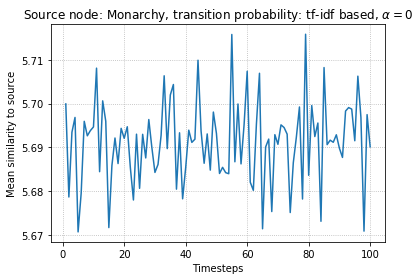

In [0]:
alpha=0
mean_sims_tfidf0 = sim_with_time(lambda s,x: similarities[art_to_id[s]][art_to_id[x]], 
                                  1000, wiki_graph, 'Monarchy', art_to_id,
                                    100, False, tf_idf_prob, similarities, dists,
                                    art_to_id, id_to_art, alpha, {}, [])
display_results(mean_sims_tfidf0, 'Monarchy', 'tf-idf based, $\\alpha=0$', 'Mean similarity to source')

['Monarchy', 'Eritrea', 'Organization', 'Aristotle', 'Rome', 'Biology', 'Mythology', 'Wasp', 'Sgt._Pepper%27s_Lonely_Hearts_Club_Band', 'Miles_Davis', 'Hello_Garci_scandal', '47_Ursae_Majoris_b', 'Schr%C3%B6dinger_equation', 'Homer', 'Jean-Jacques_Rousseau', 'British_Indian_Ocean_Territory', 'Cambrian_explosion', 'Neil_Armstrong', 'Painting', 'Globe_Theatre', 'Martin_Luther', 'Port_Louis', 'Domesticated_turkey', 'Nigeria', 'Eric_Clapton', 'Celtic_F.C.', 'Charles_Etienne_Brasseur_de_Bourbourg', 'Mecca', 'Baker_Island', 'Natural_gas', 'Scouting', 'Nematode', 'Shanghai', 'Oslo', 'Benjamin_Franklin', 'English_poetry', 'Pablo_Picasso', 'United_Malays_National_Organisation', 'Marco_Polo', 'Politics_of_the_United_Kingdom', 'Citizen_Kane', 'Attalus_I', 'Chocolate', 'Edinburgh', 'Munich', 'World_War_II', 'Islamic_republic', 'Scramble_for_Africa', 'Paraguay', 'Basil', 'Gorilla', 'Zebra_shark', 'Malawi', 'Cornea', 'Inca_Empire', 'Sun_Yat-sen', 'Alphabet', 'Speaker_of_the_United_States_House_of_Re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


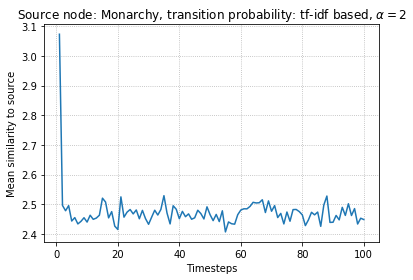

In [0]:
alpha=2
mean_sims_tfidf2 = sim_with_time(lambda s,x: similarities[art_to_id[s]][art_to_id[x]] / dists[art_to_id[s]][art_to_id[x]]
                                 if dists[art_to_id[s]][art_to_id[x]] != 0 else 0, 
                                  1000, wiki_graph, 'Monarchy', art_to_id,
                                    100, False, tf_idf_prob, similarities, dists,
                                    art_to_id, id_to_art, alpha, {}, [])
display_results(mean_sims_tfidf2, 'Monarchy', 'tf-idf based, $\\alpha=2$', 'Mean similarity to source')

['Monarchy', 'Cheers', 'Red_Sea', 'Separation_of_powers_under_the_United_States_Constitution', 'Community', 'U.S._Navy_Marine_Mammal_Program', 'Religious_Society_of_Friends', 'Malaria', 'German_Crusade%2C_1096', 'Llywelyn_the_Great', 'United_States_Constitution', 'Blue_Tit', 'John_Adams', 'Bede', 'Pound_sterling', 'Phoenix_Zoo', 'Eye_%28cyclone%29', 'Wikispecies', 'Genoa', 'History_of_science', 'Delhi', 'Armand_Jean_du_Plessis%2C_Cardinal_Richelieu', 'Music_of_Barbados', 'Adi_Shankara', 'Chola_dynasty', 'Rabbit', 'Mega_Man_X_%28character%29', 'Gaborone', 'Boston_RFC', 'Oviraptor', 'The_Legend_of_Zelda_series', 'William_Pitt_the_Younger', 'Laos', 'Horatio_Nelson%2C_1st_Viscount_Nelson', 'William_Harvey', 'Battle_of_Midway', 'Manorialism', 'Dmitri_Mendeleev', 'New_Caledonia', 'Marcel_Lefebvre', 'Tooth_enamel', 'Clarinet', 'Ethiopia', 'Emotion', 'Mercury_%28planet%29', 'Reptile', 'Cadmium', 'Baltimore%2C_Maryland', 'Aquarium', 'Gliese_876_c', 'Karl_Marx', 'Charles_I_of_England', 'The_Impo

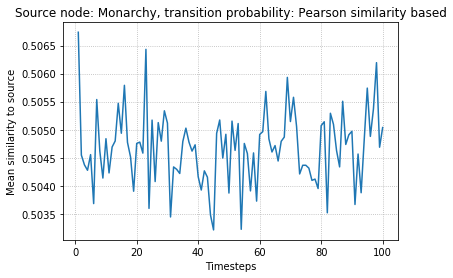

In [0]:
mean_sims_pearson = sim_with_time(lambda s,x: corr_for_node(art_to_id[s], adj_mat, [], [art_to_id[x]]),
    1000, wiki_graph, 'Monarchy', art_to_id, 100, False, pearson_prob, adj_mat, dists,
                                    art_to_id, id_to_art, {})
display_results(mean_sims_pearson, 'Monarchy', 'Pearson similarity based', 'Mean similarity to source')

-## Mean distance experiment, t=20

In [0]:
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id, 20, False, path_prob, 
                                    paths_weighted, id_to_art, {})

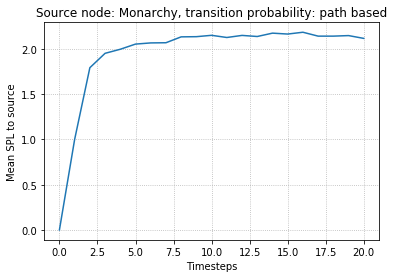

In [0]:
display_results(mean_dists, 'Monarchy', 'path based')

In [0]:
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id, 20, False, uniform_prob, 
                                    id_to_art)

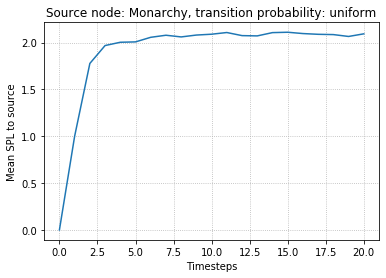

In [0]:
display_results(mean_dists, 'Monarchy', 'uniform')

In [0]:
alpha = 2
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id,
                                    20, False, tf_idf_prob, similarities, dists,
                                    art_to_id, id_to_art, alpha, {}, [])
# run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id, 100, False, uniform_prob, id_to_art)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide


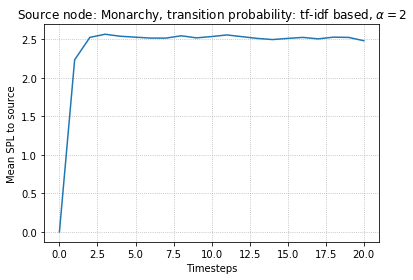

In [0]:
display_results(mean_dists, 'Monarchy', 'tf-idf based, $\\alpha=2$')

In [0]:
alpha = 0
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id,
                                    20, False, tf_idf_prob, similarities, dists,
                                    art_to_id, id_to_art, alpha, {}, [])

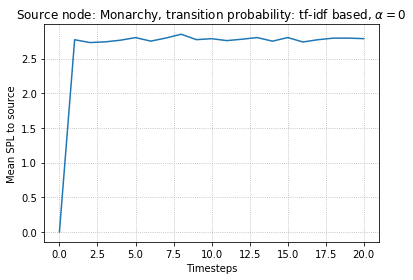

In [0]:
display_results(mean_dists, 'Monarchy', 'tf-idf based, $\\alpha=0$')

In [0]:
paths, mean_dists = run_experiments(1000, wiki_graph, 'Monarchy', dists, art_to_id,
                                    20, False, pearson_prob, adj_mat, dists,
                                    art_to_id, id_to_art, {})

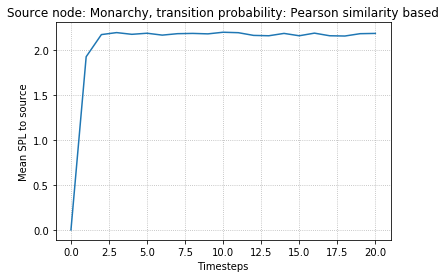

In [0]:
display_results(mean_dists, 'Monarchy', 'Pearson similarity based')

## Test

0

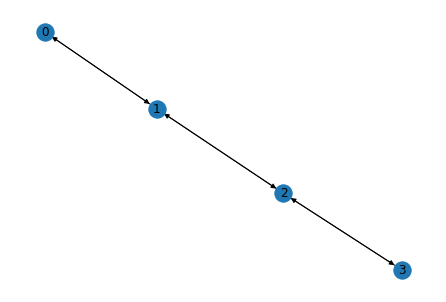

In [0]:
test = nx.DiGraph()
test.add_edge(0, 1)
test.add_edge(1, 0)

test.add_edge(2, 3)
test.add_edge(3, 2)

test.add_edge(1, 2)
test.add_edge(2, 1)

nx.draw(test, with_labels=True)
text = ['Zeroth graph is here', 'First graph is here', 'Second graph', 'Third']

from sklearn.feature_extraction.text import TfidfVectorizer 

v = TfidfVectorizer()
X = v.fit_transform(text)

X

test_sim = np.empty((X.shape[0], X.shape[0]))
np.fill_diagonal(test_sim, 1)

for i in range(X.shape[0]):
  for j in range(i + 1, X.shape[0]):
    sim = np.dot(X[i], X[j].reshape(-1, 1)).A[0][0]
    test_sim[i][j] = sim
    test_sim[j][i] = sim

test_sim
test_dist = np.ones_like(test_sim)
test_diff = []

test_idx_to_art = test_art_to_idx = {v:v for v in test.nodes}

In [0]:
10

10

## Recommendation prediction

In [0]:
from ast import literal_eval
from urllib.parse import quote

recs_df = pd.read_csv(DATA_PATH + 'recommendations3.csv',delimiter=',').drop(columns=['Unnamed: 0'])
recs_df = recs_df[recs_df['recommendations'].notna()]
recs_df['recommendations'] = recs_df['recommendations'] \
.map(lambda x: [quote(e.replace(' ', '_')) for e in literal_eval(x)])
recs_df['title'] = recs_df['title'].map(lambda x: quote(x.replace(' ', '_')))
recs_df.head()

,title,recommendations
6,Anthropology,"[Folklore, Sociology]"
16,Apollo_8,[Space_Race]
22,Atlantic_Ocean,[Atlantic_slave_trade]
58,Antigua_and_Barbuda,[United_Nations]
72,Augustus,[Augustan_literature]


In [0]:
len(recs_df)

530

In [0]:
cnt = 0
for i in range(len(recs_df)):
  cnt += len(recs_df.iloc[i]['recommendations'])

print(cnt)

791


In [0]:
lens = recs_df['recommendations'].map(lambda x: len(x))
lens[lens > 1]

6       2
82      2
89      2
109     2
131     2
       ..
4090    8
4097    4
4117    2
4134    2
4169    2
Name: recommendations, Length: 146, dtype: int64

In [0]:
# MEAN SIMILARITY FOR GROUND TRUTH:
def mean_sim_for_gt(recs_df, sim_func):
  sims = []
  for i in range(len(recs_df)):
    s = recs_df.iloc[i]['title']
    for r in recs_df.iloc[i]['recommendations']:
      if s == r:
        continue
      sims.append(sim_func(s,r))

  return np.mean(sims)

In [0]:
path_mean_sim_gt = mean_sim_for_gt(recs_df, lambda s,x: paths_weighted[s][x]['weight'] 
                               if (s,x) in paths_weighted.edges() else 1)
path_mean_sim_gt

5.305837563451776

In [0]:
tfidf0_mean_sim_gt = mean_sim_for_gt(recs_df, lambda s,x: similarities[art_to_id[s]][art_to_id[x]])
tfidf0_mean_sim_gt

5.920696809184855

In [0]:
tfidf2_mean_sim_gt = mean_sim_for_gt(recs_df, 
lambda s,x: similarities[art_to_id[s]][art_to_id[x]] / dists[art_to_id[s]][art_to_id[x]])
tfidf2_mean_sim_gt

4.051073921542633

In [0]:
pearson_mean_sim_gt = mean_sim_for_gt(recs_df, 
lambda s,x: corr_for_node(art_to_id[s], adj_mat, [], [art_to_id[x]]))
pearson_mean_sim_gt

0.5193603539134861

In [0]:
#seed here
def sample_neg_ids(rec_ids, N):
  np.random.seed(1)
  rec_ids = set(rec_ids)

  choices = list(set(np.arange(N)).difference(rec_ids))
  neg_ids = np.random.choice(choices, len(rec_ids))

  return neg_ids

def get_feature_row(row, i, source_idx, id_to_art, sim_mat, dist_mat, path_graph, adj_mat):
  sim_row = sim_mat[source_idx]
  dist_row = dist_mat[source_idx]

  rec = id_to_art[i]
  trans_num = path_graph[row['title']][rec]['weight'] if (row['title'], rec) in path_graph.edges() else 1
  corr = corr_for_node(source_idx, adj_mat, dist_mat, [i], normalize=False)[0]

  if np.isinf(sim_row[i]):
    print('!!')
  #there shouldnt be inf here, but for now whatever
  features = [sim_row[i], dist_row[i] if not np.isinf(dist_row[i]) else 10e6, 
              np.divide(1, dist_row[i], out=np.zeros(1), where=dist_row[i]!=0)[0], trans_num, corr]

  return features


def get_feature_row2(row, i, source_idx, id_to_art, sim_mat, dist_mat, path_graph, adj_mat, graph):
  sim_row = sim_mat[source_idx]
  dist_row = dist_mat[source_idx]

  rec = id_to_art[i]
  trans_num = path_graph[row['title']][rec]['weight'] if (row['title'], rec) in path_graph.edges() else 1
  corr = corr_for_node(source_idx, adj_mat, dist_mat, [i], normalize=False)[0]

  #there shouldnt be inf here, but for now whatever
  features = [sim_row[i], 
              # np.divide(1, dist_row[i], out=np.zeros(1), where=dist_row[i]!=0)[0],
              # dist_row[i] if not np.isinf(dist_row[i]) else 10e6, 
              # np.divide(sim_row[i], dist_row[i], out=np.zeros(1), where=dist_row[i]!=0)[0],
              np.divide(sim_row[i], dist_row[i]**2, out=np.zeros(1), where=dist_row[i]!=0)[0],
              trans_num, 
              graph.in_degree(id_to_art[source_idx]),
              graph.out_degree(id_to_art[source_idx]),
              graph.in_degree(rec),
              graph.out_degree(rec),
              corr]

  return features


def get_features(recs_df, art_to_id, id_to_art, sim_mat, dist_mat, path_graph, adj_mat,graph):
  feature_mat = []
  y = []

  for i in range(len(recs_df)):
    row = recs_df.iloc[i]
    source_idx = art_to_id[row['title']]

    rec_ids = [art_to_id[rec] for rec in row['recommendations']]
    neg_ids = sample_neg_ids(rec_ids, len(sim_mat))

    for i in rec_ids:
      features = get_feature_row2(row, i, source_idx, id_to_art, sim_mat, dist_mat, path_graph, adj_mat, graph)
      feature_mat.append(features)
      y.append(1)

    for i in neg_ids:

      features = get_feature_row2(row, i, source_idx, id_to_art, sim_mat, dist_mat, path_graph, adj_mat,graph)
      feature_mat.append(features)
      y.append(0)

  return np.array(feature_mat), np.array(y)

In [0]:
X, y = get_features(recs_df, art_to_id, id_to_art, similarities, dists, paths_weighted, adj_mat, wiki_graph)
X.shape

!
!
!


(1582, 8)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [0]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC

classifier = LogisticRegression(penalty='l2', 
                                # solver='saga',
                                C=10e8,
                                l1_ratio=0.4, max_iter=50, random_state=1)
# classifier = SVC(gamma='auto', kernel='rbf')
# classifier = SGDClassifier(penalty='elasticnet',loss='log', l1_ratio=0.1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

Accuracy:  0.8315789473684211
Precision:  0.9322033898305084
Recall:  0.7081545064377682
F1:  0.8048780487804877


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


In [0]:
classifier.coef_

array([[ 2.76429410e-09, -3.24241023e-08,  2.21992917e-09,
         1.36758709e-08,  1.63285474e-08,  2.65780804e-08,
        -9.34286444e-11]])

In [0]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC

classifier = LogisticRegression(penalty='l1', 
                                solver='saga',
                                l1_ratio=0.1, max_iter=2000, random_state=1)
# classifier = SVC(gamma='auto', kernel='rbf')
# classifier = SGDClassifier(penalty='elasticnet',loss='log', l1_ratio=0.1)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1506: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))


Accuracy:  0.8526315789473684
Precision:  0.9222797927461139
Recall:  0.7639484978540773
F1:  0.8356807511737089


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [0]:
classifier.coef_

array([[ 5.48405823e-09, -3.24241062e-08,  4.39742882e-09,
         5.30880447e-08, -1.46846877e-10]])

In [0]:
import statsmodels.api as sm
X_train_const = sm.add_constant(X_train)
logit_model=sm.Logit(y_train,X_train_const)
result=logit_model.fit_regularized()
print(result.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3883145767569772
            Iterations: 48
            Function evaluations: 62
            Gradient evaluations: 48
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1107
Model:                          Logit   Df Residuals:                     1098
Method:                           MLE   Df Model:                            8
Date:                Mon, 06 Jan 2020   Pseudo R-squ.:                  0.4398
Time:                        00:48:26   Log-Likelihood:                -429.86
converged:                       True   LL-Null:                       -767.28
Covariance Type:            nonrobust   LLR p-value:                1.877e-140
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.6/dist-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [0]:
  # features = [sim_row[i], 
    #             np.divide(1, dist_row[i], out=np.zeros(1), where=dist_row[i]!=0)[0],
        #      # dist_row[i] if not np.isinf(dist_row[i]) else 10e6, 
  #             np.divide(sim_row[i], dist_row[i], out=np.zeros(1), where=dist_row[i]!=0)[0],
  #             np.divide(sim_row[i], dist_row[i]**2, out=np.zeros(1), where=dist_row[i]!=0)[0],
  #             trans_num, 
  #             graph.in_degree(id_to_art[source_idx]),
  #             graph.out_degree(id_to_art[source_idx]),
  #             graph.in_degree(rec),
  #             graph.out_degree(rec),
  #             corr]

X_test_const = sm.add_constant(X_test)
y_pred = result.predict(X_test_const)
y_pred = np.where(y_pred >0.5, 1, 0)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred))

Accuracy:  0.8336842105263158
Precision:  0.9375
Recall:  0.7081545064377682
F1:  0.8068459657701712


In [0]:
result.params

array([-4.57985542e+00,  3.83456802e-01,  1.46502615e+00,  9.64219702e-03,
        3.65445259e-04, -9.21373807e-03, -2.03571247e-03,  3.39567453e-02,
       -4.45957196e+00])

In [0]:
result.tvalues

array([-12.80714899,  10.99223473,  12.25877323,  -0.15623491,
        -2.96252787])

## Recommendations

In [0]:
#TOP K
k = 50

In [0]:
def apk(actual, predicted, k=None):
    if k is None:
      k = len(predicted)
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=None):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def cum_reciprocal_rank(actual, predicted, k=None):
  if k is None:
    k = len(predicted)
  if len(predicted)>k:
    predicted = predicted[:k]

  score = 0.0

  for i,p in enumerate(predicted):
    if p in actual and p not in predicted[:i]:
      score += 1.0 / (i+1.0)

  # ideal = np.sum(1.0 / (np.arange(len(actual)) + 1))
  ideal = np.sum(1.0 / (np.arange(min(k, len(actual))) + 1))

  return score / ideal

def mean_cum_reciprocal_rank(actual, predicted, k=None):
  return np.mean([cum_reciprocal_rank(a,p,k) for a,p in zip(actual,predicted)])

def get_recommendations(rw, node, graph, k):
  neighbors = set(graph.neighbors(node))
  recs = [rec for rec in rw if rec not in neighbors and rec != node][:k]
  return recs

def eval_recommendations(recs_df, k, graph, num_iter, num_exp, show_pr, trans_func, *args):
  actual = recs_df['recommendations'].tolist()

  maps = []
  crrs = []
  experiment_res = []
  for i in tqdm(range(num_exp)):
    predicted = []
    for j in range(len(recs_df)):
    # for j in tqdm(range(len(recs_df))):
      if len(recs_df.iloc[j]['recommendations']) == 1:
        continue
      title = recs_df.iloc[j]['title']
      # if not title in graph.nodes:
      #   print("Node {} is not in graph. Skipping it...".format(title))
      #   continue
      rw = random_walk(graph, title, num_iter, show_pr, trans_func, *args)
      rw = pd.Series(rw).value_counts().to_dict()
      recs = get_recommendations(rw.keys(), title, graph, k)
      predicted.append(recs)
      experiment_res.append({title: recs})

    map_k = mapk(actual, predicted, k)
    crr = mean_cum_reciprocal_rank(actual, predicted, k)
    maps.append(map_k)
    crrs.append(crr)
  print("Average MAP@{} after {} runs: ".format(k, num_exp), np.mean(maps))
  print("Mean cumulative reciprocal rank@{} after {} runs: ".format(k, num_exp), np.mean(crrs))

  return maps, crrs, experiment_res


In [0]:
uniform_maps, uniform_crrs, uniform_exp_res = eval_recommendations(recs_df,
 k, wiki_graph, 1000, 5, False, uniform_prob, id_to_art)


Average MAP@50 after 5 runs:  0.0027428182074867866
Mean cumulative reciprocal rank@50 after 5 runs:  0.003188360762935917


In [0]:
path_maps, path_crrs, path_exp_res = eval_recommendations(recs_df,
k, wiki_graph, 1000, 5, False, path_prob, paths_weighted, id_to_art, {})


Average MAP@50 after 5 runs:  0.00438656810683233
Mean cumulative reciprocal rank@50 after 5 runs:  0.005227025884324251


In [0]:
pearson_maps, pearson_crrs, pearson_exp_res = eval_recommendations(recs_df, 
k, wiki_graph, 1000, 5, False, pearson_prob, adj_mat, dists, art_to_id, id_to_art, {})


Average MAP@50 after 5 runs:  0.0012807115054627133
Mean cumulative reciprocal rank@50 after 5 runs:  0.0013372798188107163


In [0]:
alpha = 0
tfidf_a0_maps, tfidf_a0_crrs, tfidf_a0_exp_res = eval_recommendations(recs_df, 
k, wiki_graph, 1000, 5, False, tf_idf_prob, similarities, dists, art_to_id, id_to_art, alpha, {}, [])


Average MAP@50 after 5 runs:  0.0017612376180236072
Mean cumulative reciprocal rank@50 after 5 runs:  0.001808566233277381


In [0]:
alpha = 2
tfidf_a2_maps, tfidf_a2_crrs, tfidf_a2_exp_res = eval_recommendations(recs_df, 
k, wiki_graph, 1000, 5, False, tf_idf_prob, similarities, dists, art_to_id, id_to_art, alpha, {}, [])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide



Average MAP@50 after 5 runs:  0.0012816775364997003
Mean cumulative reciprocal rank@50 after 5 runs:  0.0014310370994655118


In [0]:
import json

with open('uniform1000paths.json', 'w') as fp:
    json.dump(uniform_exp_res, fp)

with open('transbased1000paths.json', 'w') as fp:
    json.dump(path_exp_res, fp)

with open('pearson1000paths.json', 'w') as fp:
    json.dump(pearson_exp_res, fp)

with open('tfidf0_1000paths.json', 'w') as fp:
    json.dump(tfidf_a0_exp_res, fp)

with open('tfidf2_1000paths.json', 'w') as fp:
    json.dump(tfidf_a2_exp_res, fp)

In [0]:
with open('uniform1000walks_5exp_k50.json', 'w') as fp:
    json.dump(uniform_exp_res, fp)

with open('transbased1000walks_5exp_k50.json', 'w') as fp:
    json.dump(path_exp_res, fp)

with open('pearson1000walks_5exp_k50.json', 'w') as fp:
    json.dump(pearson_exp_res, fp)

with open('tfidf0_1000walks_5exp_k50.json', 'w') as fp:
    json.dump(tfidf_a0_exp_res, fp)

with open('tfidf2_1000walks_5exp_k50.json', 'w') as fp:
    json.dump(tfidf_a2_exp_res, fp)

In [0]:
while(True):
  np.arange(100) + np.arange(100) * 3

In [0]:
from urllib.parse import unquote
print(path_exp_res[5].keys())
for v in path_exp_res[5].values():
  for el in v:
    print(unquote(el.replace('_', ' '))+",")

dict_keys(['British_English'])
United States,
Europe,
Christianity,
France,
Earth,
Mammal,
Africa,
Telephone,
Atlantic Ocean,
Latin,
Music,
Animal,
Thailand,
Mediterranean Sea,
Science,
California,
Japan,
Gold,
European Union,
Plant,
Television,
Mathematics,
Cretaceous,
Finland,
Religion,
Norway,
Water,
Roman Catholic Church,
Chemistry,
Great Britain,
Telecommunication,
China,
Volcano,
North America,
Egypt,
Gravitation,
Romania,
Whale shark,
Nuclear weapon,
Russia,
Light,
United Nations,
Lion,
Cold War,
People's Republic of China,
Astronomy,
Zebra,
Physics,
Chemical element,
Alexander Graham Bell,


In [0]:
from urllib.parse import unquote
print(tfidf_a0_exp_res[5].keys())
for v in tfidf_a0_exp_res[5].values():
  for el in v:
    print(unquote(el.replace('_', ' '))+",")

dict_keys(['British_English'])
Whitney Joins The JAMs,
Australian constitutional law,
Lunar eclipse,
Krypton,
Volleyball,
Walt Disney,
Igor Stravinsky,
Aesthetics,
Bread,
Mitochondrial Eve,
Epazote,
Georg von Boeselager,
Tacitean studies,
Hampstead Heath,
Slavery,
Amsterdam,
Superconductivity,
Linux,
Open cluster,
Flag of Hong Kong,
Tropical Storm Bonnie (2004),
Retinol,
Lancia Flaminia,
HD 217107,
Sand,
Kurt Cobain,
William Shakespeare,
Psittacosaurus,
Cheers,
Pygmy Hippopotamus,
Zebra,
Niger,
Ship,
Medicine,
Morphine,
Kaffir lime,
Hurricane Dennis,
Mercia,
Romania,
J. K. Rowling,
Biotechnology,
Forensic facial reconstruction,
Star,
North America,
Minnesota,
Rabbit,
Revised Standard Version,
Great Lakes,
Latvia,
Forth,


In [0]:
from urllib.parse import unquote
print(tfidf_a2_exp_res[5].keys())
for v in tfidf_a2_exp_res[5].values():
  for el in v:
    print(unquote(el.replace('_', ' '))+",")

dict_keys(['British_English'])
Arabic language,
Charles Dickens,
Gadolinium,
Animal,
Japan,
Crime,
Onion,
Cocoa,
Drinking water,
Beirut,
Currency,
Ottoman Empire,
Cormorant,
Mauritania,
Hydrochloric acid,
Extinction,
Thomas Aquinas,
Richard Nixon,
Naval Battle of Guadalcanal,
Portuguese language,
U2,
Music,
Monty Python,
Detroit, Michigan,
Mind,
Guild,
El Aaiún,
Linear algebra,
Drought,
Ammonia,
Welding,
Raney nickel,
J. K. Rowling,
Vietnam,
Finance,
Photosynthesis,
Buckingham Palace,
Tantalum,
Henry VII of England,
George III of the United Kingdom,
Thermodynamics,
Liverpool,
Isle of Man,
Saint Petersburg,
Costa Rica,
Hernán Cortés,
West Bank,
Kyoto Protocol,
Herbivore,
Canaletto,


In [0]:
from urllib.parse import unquote
print(pearson_exp_res[5].keys())
for v in pearson_exp_res[5].values():
  for el in v:
    print(unquote(el.replace('_', ' '))+",")

dict_keys(['British_English'])
Mixed-breed dog,
Moldova,
Music of Thailand,
Education,
Renminbi,
Montevideo,
Westport Country Playhouse,
Vole,
Johannes Gutenberg,
Investment banking,
Tea,
Santamaría (volcano),
Dundee United F.C.,
David Attenborough,
Copenhagen Fire of 1728,
Quatermass and the Pit,
The Canadian,
Henry David Thoreau,
List of European countries,
San Jose, California,
William Hogarth,
Pompeii,
Lake Baikal,
Tropical Storm Henri (2003),
Nicobar Long-tailed Macaque,
Nadia Comăneci,
The Lord of the Rings,
History of nuclear weapons,
Faroe Islands,
Avalanche,
1973 oil crisis,
19th century,
Lord Voldemort,
Video,
Speed of light,
Himalayas,
Sauroposeidon,
Neon,
Bison,
Wake Island,
Thiamine,
Ununpentium,
Sand,
Outer Hebrides,
Alchemy,
Anthropology,
Bob Marley,
Congo River,
Ernest Rutherford,
Snow,


In [0]:
weighted = random_walk(wiki_graph, list(gcc.nodes())[6], 10000, True, path_prob, paths_weighted)
weighted = pd.Series(weighted).value_counts().to_dict()
get_recommendations(weighted.keys(), 'Monarchy', wiki_graph, k)

['United_States',
 'Europe',
 'Africa',
 'Earth',
 'North_America',
 'Germany',
 'Mammal',
 'English_language',
 'Animal',
 'Viking']

In [0]:
uniform = random_walk(wiki_graph, 'Monarchy', 10000, True, uniform_prob)
uniform = pd.Series(uniform).value_counts().to_dict()
get_recommendations(uniform.keys(), 'Monarchy', wiki_graph, 10)

113
22
39
57
40
31
112
100
84
35
8
22
25
60
47
45
53
63
26
30
64
139
137
29
70
53
16
24
8
8
16
4
16
87
40
64
44
12
159
212
31
294
23
17
42
44
67
89
37
15
34
43
81
168
55
32
35
14
6
60
67
21
19
24
29
52
99
67
76
51
6
24
13
56
169
28
98
47
26
86
44
69
23
85
139
48
64
40
17
108
69
74
44
89
27
39
40
16
19
85
16
34
39
36
35
85
22
236
139
26
49
14
6
17
105
65
37
22
85
83
43
56
30
49
47
47
12
107
75
25
39
23
30
1
18
13
11
29
56
10
20
16
34
52
60
48
118
21
74
19
10
48
29
10
20
23
25
137
41
25
48
40
24
90
98
96
109
145
11
20
122
212
50
84
58
42
39
26
113
46
20
43
29
40
41
87
40
168
22
27
91
96
105
42
159
39
27
31
16
90
67
74
57
67
23
36
25
10
54
24
35
168
37
86
86
116
85
47
61
30
180
133
34
47
139
22
19
55
46
65
34
63
45
38
294
37
39
39
66
10
10
30
113
16
57
168
172
27
172
16
52
29
40
43
37
42
18
20
9
27
55
48
14
17
33
68
12
34
22
28
24
12
52
28
70
26
21
137
32
99
24
27
48
24
22
119
70
47
4
119
45
45
294
68
47
26
61
39
81
27
70
18
38
61
56
75
47
63
7
160
113
33
45
68
54
46
129
30
207
56
119
78


ValueError: ignored

In [0]:
adj_mat = nx.adjacency_matrix(wiki_graph, weight=None).toarray() 
pearson = random_walk(wiki_graph, list(gcc.nodes())[6], 1000, True, pearson_prob, 
            adj_mat, dists, art_to_id, id_to_art)

pearson = pd.Series(pearson).value_counts().to_dict()
get_recommendations(pearson.keys(), 'Monarchy', wiki_graph, k)

['Poland',
 'Bible',
 'Hamburg',
 'Latin_America',
 'United_Nations',
 'Boston%2C_Massachusetts',
 'Monarchy',
 'French_language',
 'Russia',
 'Ocean']

In [0]:
alpha = 0
tfidf = random_walk(wiki_graph, list(gcc.nodes())[6], 10000, True, tf_idf_prob, 
            similarities, dists, art_to_id, id_to_art, alpha, [])
tfidf = pd.Series(tfidf).value_counts().to_dict()
get_recommendations(tfidf.keys(), 'Monarchy', wiki_graph, k)

['Piccadilly_Circus',
 'Lebanon',
 'Margaret_Sanger',
 'Sri_Lanka',
 'Sasha_%28DJ%29',
 'Boat',
 'University_of_Chicago',
 'Wrench',
 'Costume_design',
 'Music_of_the_trecento']

In [0]:
alpha = 2
tfidf = random_walk(wiki_graph, list(gcc.nodes())[6], 10000, True, tf_idf_prob, 
            similarities, dists, art_to_id, id_to_art, alpha, [])
tfidf = pd.Series(tfidf).value_counts().to_dict()
get_recommendations(tfidf.keys(), 'Monarchy', wiki_graph, k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in true_divide


['Germany',
 'Europe',
 'Property',
 'United_States',
 'Turkey',
 'Ocean',
 'Day',
 'Nigeria',
 'Soviet_Union',
 'Libya']

In [0]:
rw10000 = random_walk(gcc, list(gcc.nodes())[6], 10000, path_prob, paths_weighted)

In [0]:
rws10000 = pd.Series(rw10000)
rws10000.value_counts()[:20]

In [0]:
rw1000 = random_walk(gcc, list(gcc.nodes())[6], 1000, path_prob, paths_weighted)
rws1000 = pd.Series(rw1000)
rws1000.value_counts()[:10]

Europe            19
United_States     19
United_Kingdom    15
Earth             10
England           10
Telephone         10
Human              9
Mammal             9
Periodic_table     9
Africa             8
dtype: int64